In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [14]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Santhosh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Santhosh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
news_d = pd.read_csv("train.csv")


In [16]:
print("Shape of News data:", news_d.shape)
print("News data columns", news_d.columns)


Shape of News data: (20800, 5)
News data columns Index(['id', 'title', 'author', 'text', 'label'], dtype='object')


In [17]:
news_d.head()


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [18]:
txt_length = news_d.text.str.split().str.len()
txt_length.describe()


count    20761.000000
mean       760.308126
std        869.525988
min          0.000000
25%        269.000000
50%        556.000000
75%       1052.000000
max      24234.000000
Name: text, dtype: float64

In [19]:
title_length = news_d.title.str.split().str.len()
title_length.describe()


count    20242.000000
mean        12.420709
std          4.098735
min          1.000000
25%         10.000000
50%         13.000000
75%         15.000000
max         72.000000
Name: title, dtype: float64

1: Unreliable
0: Reliable
Distribution of labels:
1    10413
0    10387
Name: label, dtype: int64


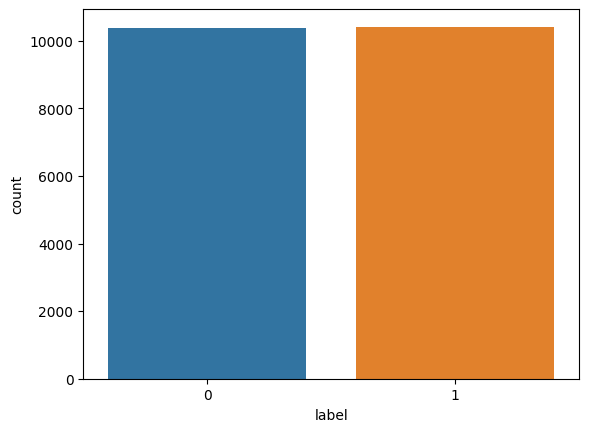

In [20]:
sns.countplot(x="label", data=news_d)
print("1: Unreliable")
print("0: Reliable")
print("Distribution of labels:")
print(news_d.label.value_counts())


In [21]:
print(round(news_d.label.value_counts(normalize=True),2)*100);

1    50.0
0    50.0
Name: label, dtype: float64


In [22]:
# Constants that are used to sanitize the datasets

column_n = ['id', 'title', 'author', 'text', 'label']
remove_c = ['id', 'author']
categorical_features = []
target_col = ['label']
text_f = ['title', 'text']


In [23]:
# Clean Datasets
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter

ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

# Removed unused clumns


def remove_unused_c(df, column_n=remove_c):
    df = df.drop(column_n, axis=1)
    return df

# Impute null values with None


def null_process(feature_df):
    for col in text_f:
        feature_df.loc[feature_df[col].isnull(), col] = "None"
    return feature_df


def clean_dataset(df):
    # remove unused column
    df = remove_unused_c(df)
    #impute null values
    df = null_process(df)
    return df

# Cleaning text from unused characters


def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # removing urls
    # remove everything but characters and punctuation
    text = str(text).replace(r'[^\.\w\s]', ' ')
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip()
    #text = ' '.join(text)
    return text

## Nltk Preprocessing include:
# Stop words, Stemming and Lemmetization
# For our project we use only Stop word removal


def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    #text = ' '.join([word for word in wordlist if word not in stopwords_dict])
    #text = [ps.stem(word) for word in wordlist if not word in stopwords_dict]
    text = ' '.join([wnl.lemmatize(word)
                    for word in wordlist if word not in stopwords_dict])
    return text


In [24]:
import nltk
nltk.download('omw-1.4')
# Perform data cleaning on train and test dataset by calling clean_dataset function
df = clean_dataset(news_d)
# apply preprocessing on text through apply method by calling the function nltk_preprocess
df["text"] = df.text.apply(nltk_preprocess)
# apply preprocessing on title through apply method by calling the function nltk_preprocess
df["title"] = df.title.apply(nltk_preprocess)


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Santhosh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [25]:
df.head()


,title,text,label
0,house dem aide didnt even see comeys letter ja...,house dem aide didnt even see comeys letter ja...,1
1,flynn hillary clinton big woman campus breitbart,ever get feeling life circle roundabout rather...,0
2,truth might get fired,truth might get fired october 29 2016 tension ...,1
3,15 civilian killed single u airstrike identified,video 15 civilian killed single u airstrike id...,1
4,iranian woman jailed fictional unpublished sto...,print iranian woman sentenced six year prison ...,1


In [26]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# initialize the word cloud
wordcloud = WordCloud(background_color='black', width=800, height=600)
# generate the word cloud by passing the corpus
text_cloud = wordcloud.generate(' '.join(df['text']))
# plotting the word cloud
plt.figure(figsize=(20, 30))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()


KeyboardInterrupt: 

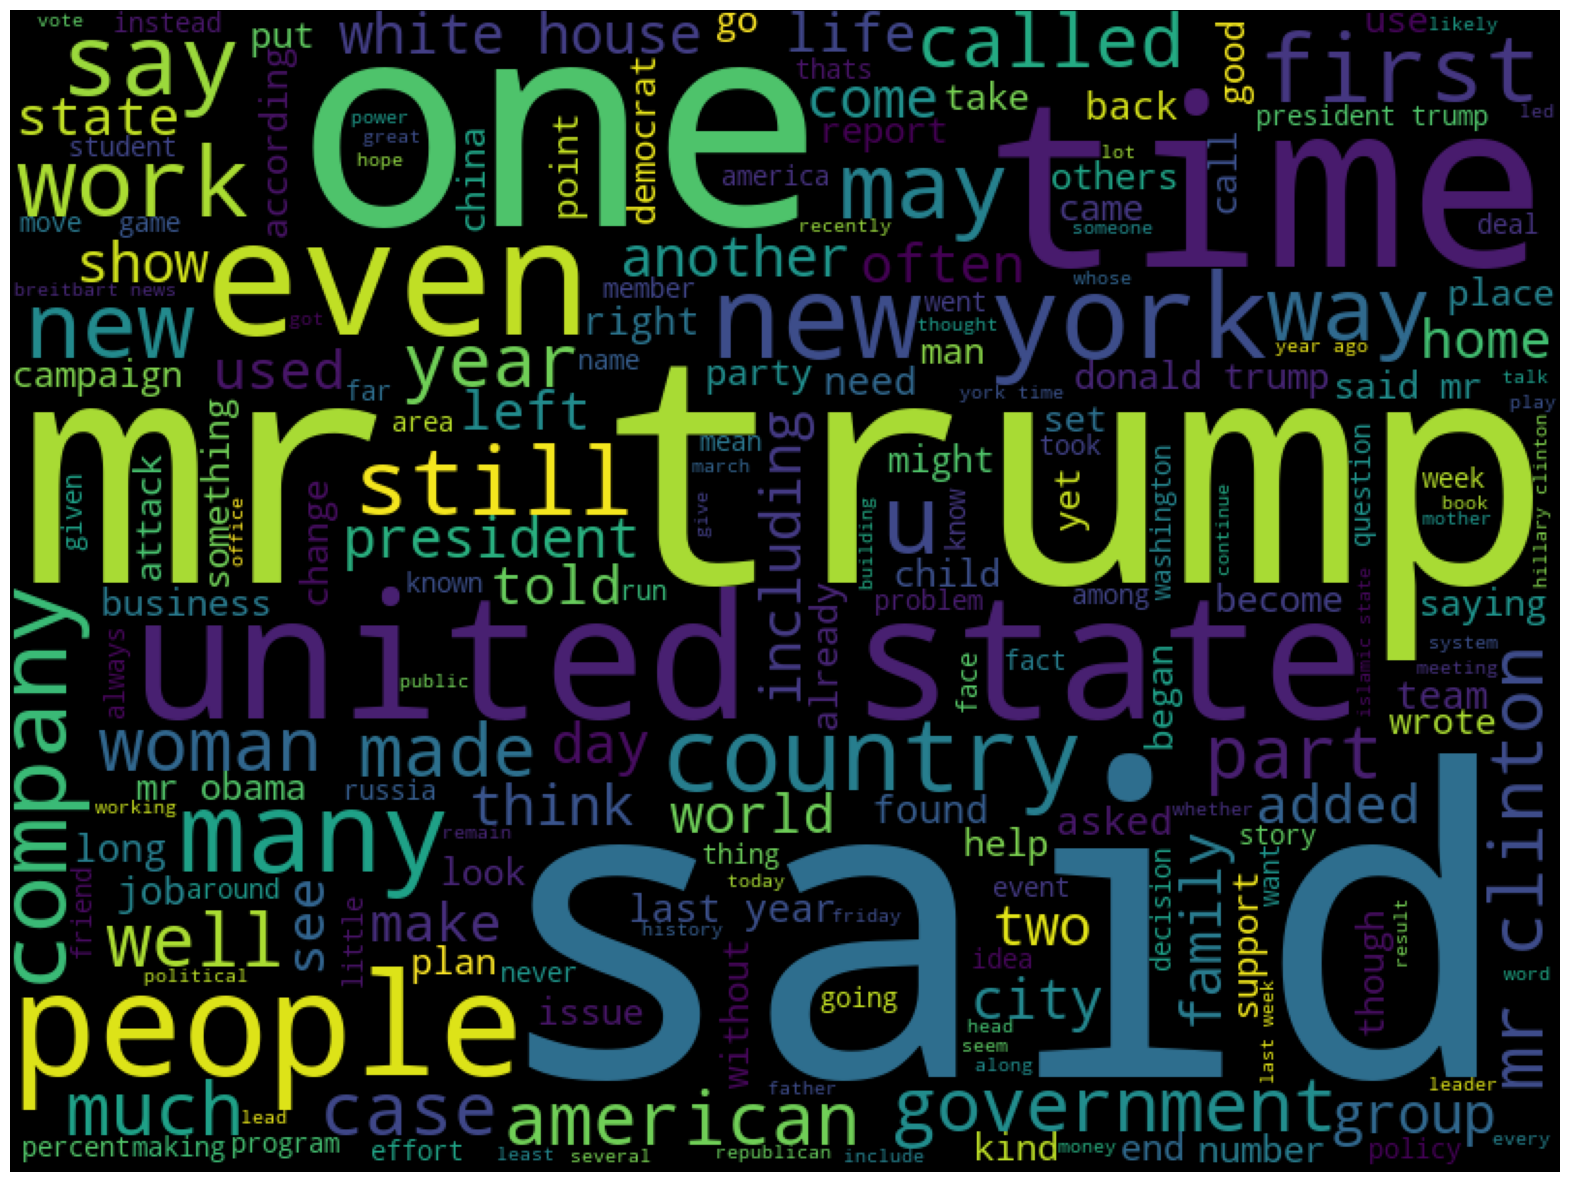

In [ ]:
true_n = ' '.join(df[df['label'] == 0]['text'])
wc = wordcloud.generate(true_n)
plt.figure(figsize=(20, 30))
plt.imshow(wc)
plt.axis('off')
plt.show()


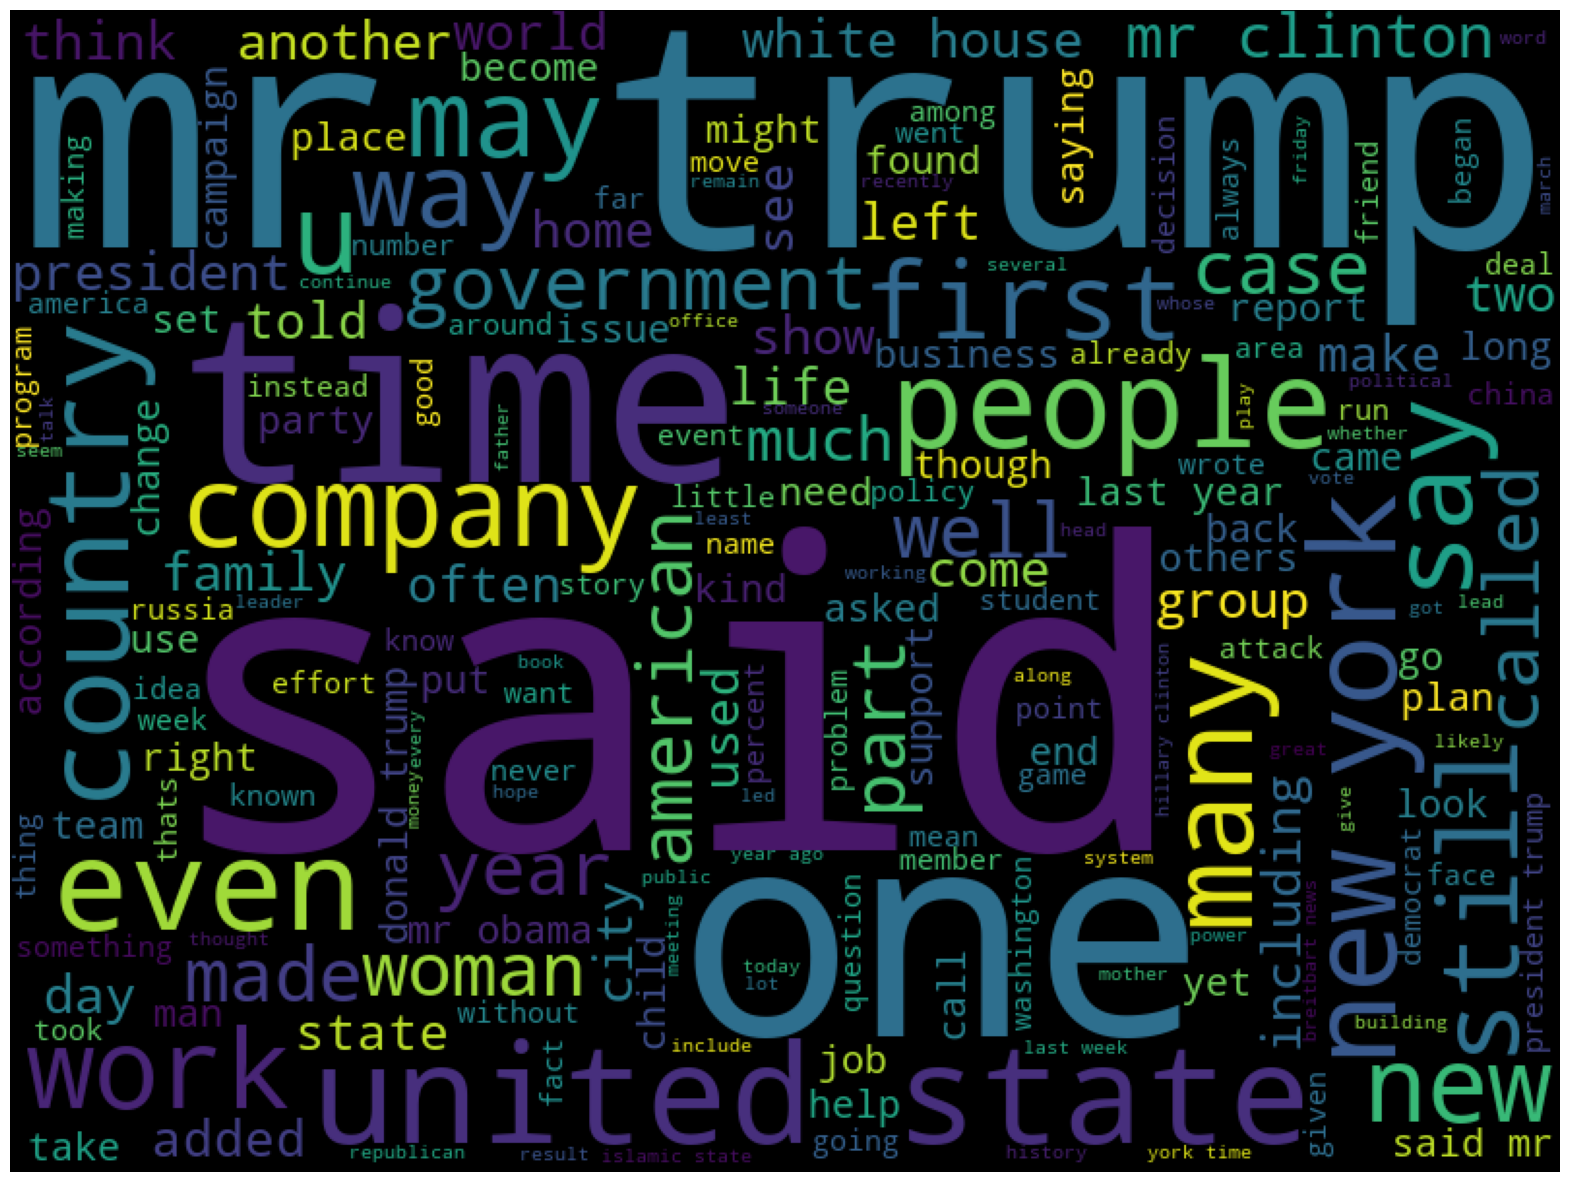

In [ ]:
true_n = ' '.join(df[df['label'] == 0]['text'])
wc = wordcloud.generate(true_n)
plt.figure(figsize=(20, 30))
plt.imshow(wc)
plt.axis('off')
plt.show()


In [ ]:
def plot_top_ngrams(corpus, title, ylabel, xlabel="Number of Occurences", n=2):
  """Utility function to plot top n-grams"""
  true_b = (pd.Series(nltk.ngrams(corpus.split(), n)).value_counts())[:20]
  true_b.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.show()


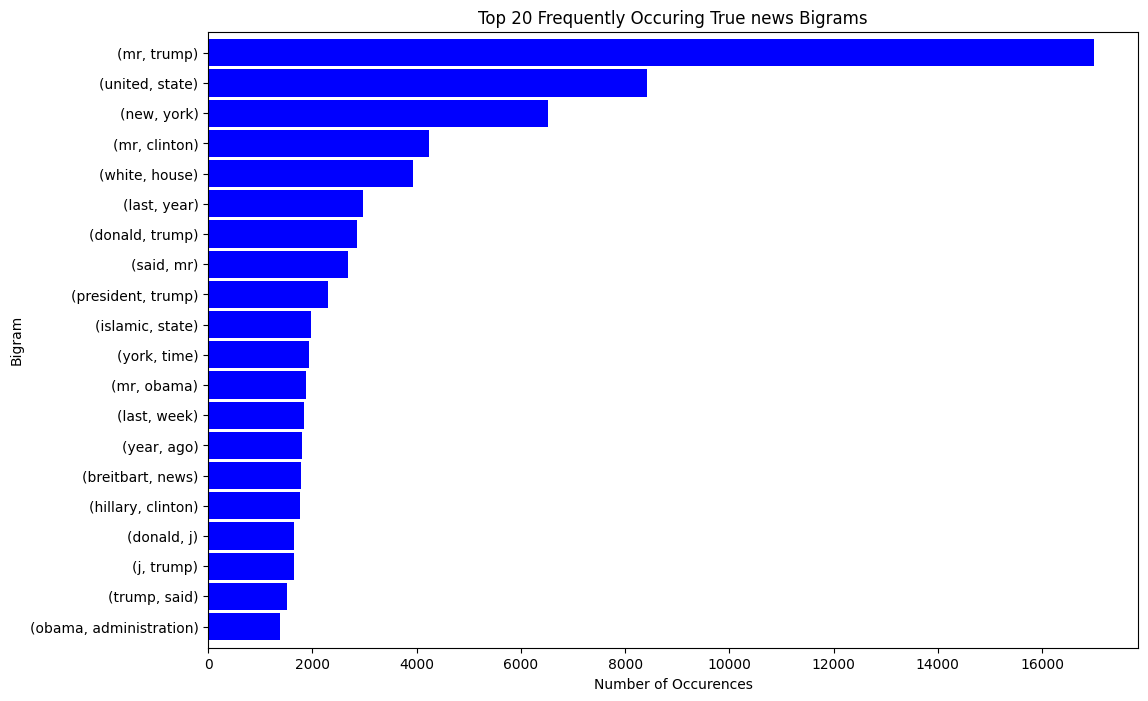

In [ ]:
plot_top_ngrams(
    true_n, 'Top 20 Frequently Occuring True news Bigrams', "Bigram", n=2)


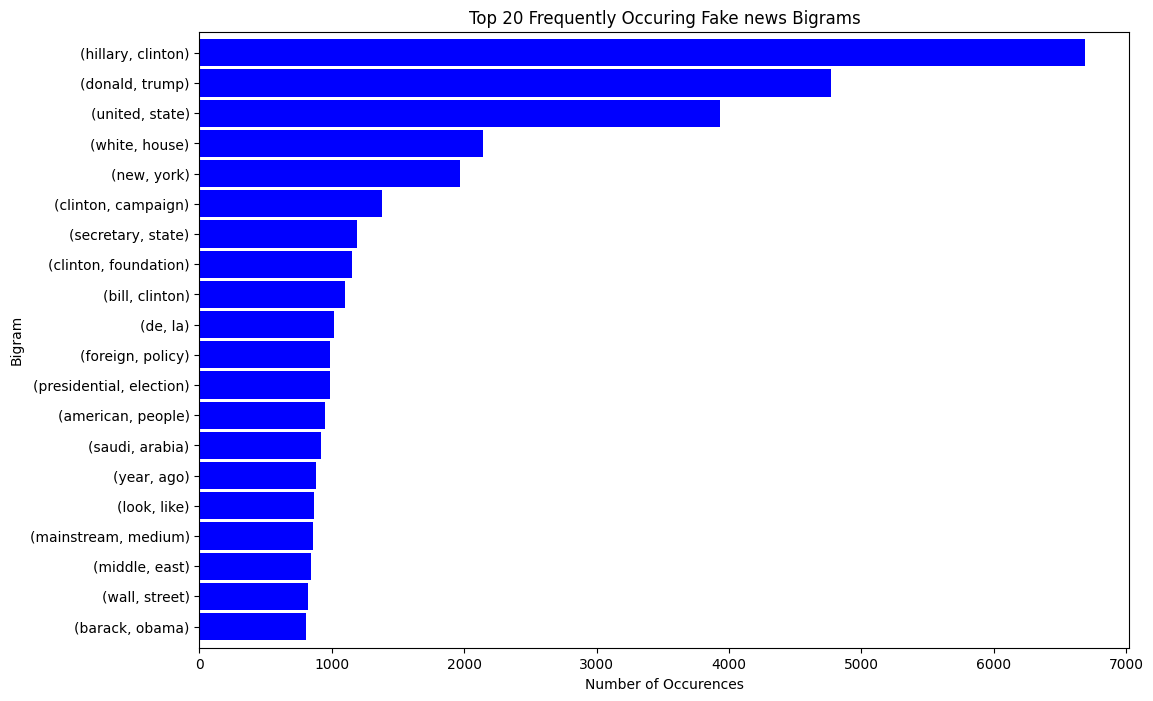

In [ ]:
plot_top_ngrams(
    fake_n, 'Top 20 Frequently Occuring Fake news Bigrams', "Bigram", n=2)


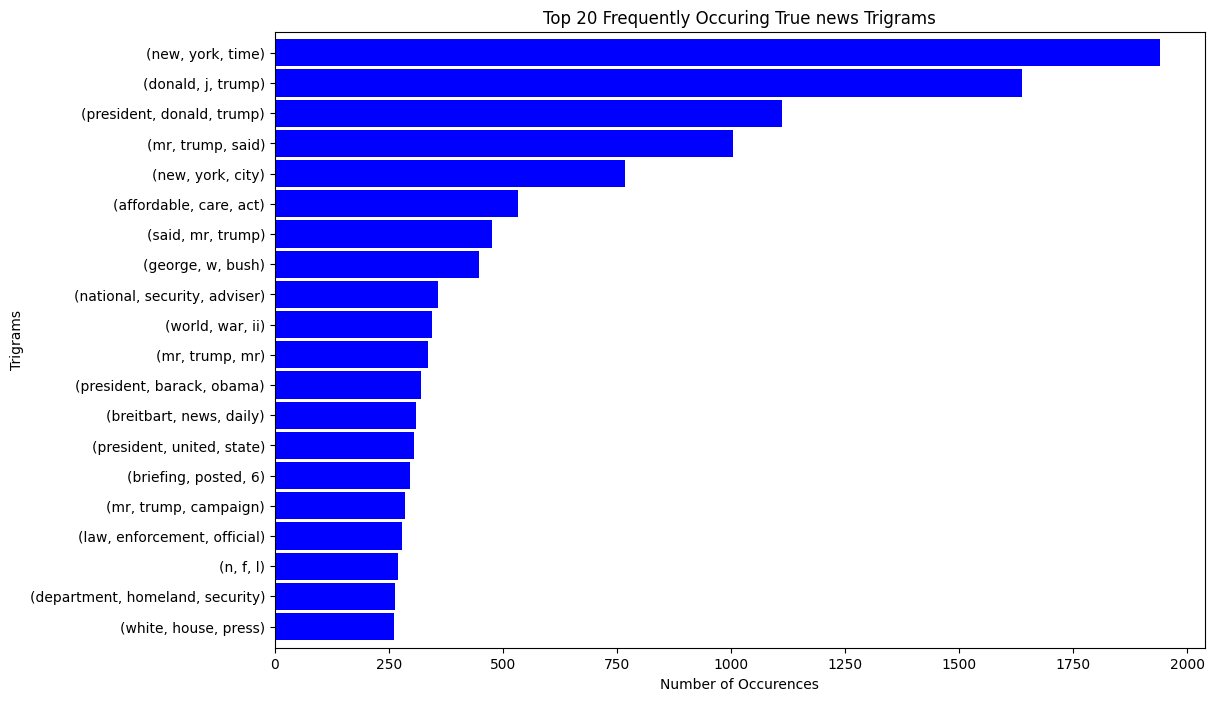

In [ ]:
plot_top_ngrams(
    true_n, 'Top 20 Frequently Occuring True news Trigrams', "Trigrams", n=3)


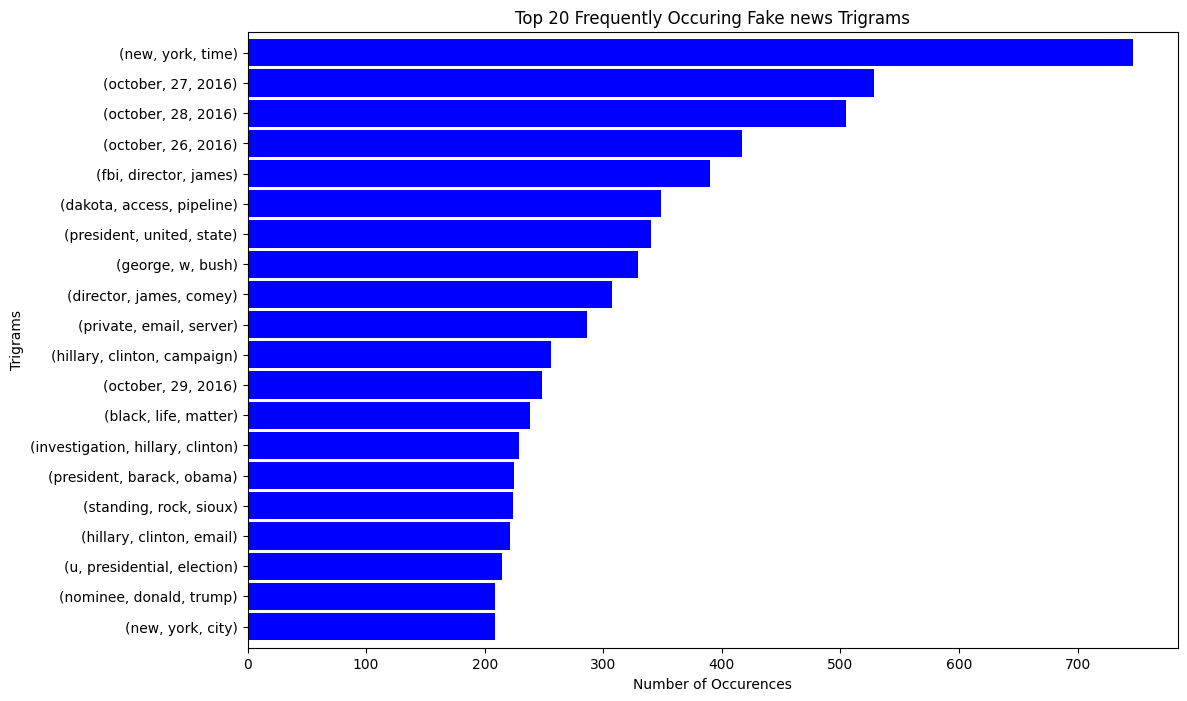

In [ ]:
plot_top_ngrams(
    fake_n, 'Top 20 Frequently Occuring Fake news Trigrams', "Trigrams", n=3)


In [27]:
# Building a Classifier by Fine-tuning BERT

import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.model_selection import train_test_split

import random


c:\Users\Santhosh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]
